In [ ]:
!pip install tensorflow tensorflow-probability
!pip install d2l==1.0.0a1.post0

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
class Assignmet1(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.TrainingData = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.TestData = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [ ]:
data = Assignment1(batch_size=64)
print(data.TrainingData.shape)
print(data.TestData.shape)

(1460, 81)
(1459, 80)


In [ ]:
data = Assignment1(batch_size=64)

In [ ]:
@d2l.add_to_class(Assignment1)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.TrainingData.drop(columns=['Id', label]),
         self.TestData.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding.
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.TrainingData.shape[0]].copy()
    self.train[label] = self.TrainingData[label]
    self.val = features[self.TrainingData.shape[0]:].copy()

In [ ]:
data.preprocess()
data.train.shape

(1460, 332)

In [ ]:
@d2l.add_to_class(Assignment1)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: tf.constant(x.values, dtype=tf.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               tf.reshape(tf.math.log(get_tensor(data[label])), (-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [ ]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(Assignment1(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [ ]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation log mse = 0.258571890592575


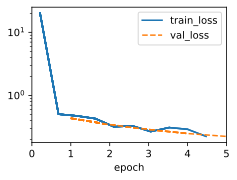

In [ ]:
trainer = d2l.Trainer(max_epochs=5)
models = k_fold(trainer, data, k= 5 , lr= 0.01)

In [ ]:
preds = [model(tf.constant(data.val.values, dtype=tf.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = tf.reduce_mean(tf.exp(tf.concat(preds, 1)), 1)
submission = pd.DataFrame({'Id':data.TestData.Id,
                           'SalePrice':ensemble_preds.numpy()})
submission.to_csv('submission.csv', index=False)